In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *
import glob

In [3]:
torch.cuda.set_device(0)

# Preparing the Data

### Load CSV Files and Fill NAN's

In [5]:
record = pd.read_csv('/data2/datasets/mimic-cxr/mimic-cxr-2.0.0.physionet.org/cxr-record-list.csv')
record.head()

,subject_id,study_id,dicom_id,path
0,10000032,50414267,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,files/p10/p10000032/s50414267/02aa804e-bde0afd...
1,10000032,50414267,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,files/p10/p10000032/s50414267/174413ec-4ec4c1f...
2,10000032,53189527,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,files/p10/p10000032/s53189527/2a2277a9-b0ded15...
3,10000032,53189527,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,files/p10/p10000032/s53189527/e084de3b-be89b11...
4,10000032,53911762,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,files/p10/p10000032/s53911762/68b5c4b1-227d048...


In [6]:
expert = pd.read_csv('/data2/datasets/mimic-cxr/mimic-cxr-2.0.0.physionet.org/mimic-cxr-2.0.0-chexpert.csv')
expert = expert.fillna(0)
expert.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,10000032,53189527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,10000032,53911762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10000032,56699142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10000764,57375967,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0


In [6]:
# create label df with only 1's for positive values
expert_zeros = expert.copy().replace(-1.0, 0.0)
expert_zeros.head()

,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,10000032,50414267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,10000032,53189527,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,10000032,53911762,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,10000032,56699142,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,10000764,57375967,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
study = pd.read_csv('/data2/datasets/mimic-cxr/mimic-cxr-2.0.0.physionet.org/cxr-study-list.csv')
study.head()

,subject_id,study_id,path
0,10000032,50414267,files/p10/p10000032/s50414267.txt
1,10000032,53189527,files/p10/p10000032/s53189527.txt
2,10000032,53911762,files/p10/p10000032/s53911762.txt
3,10000032,56699142,files/p10/p10000032/s56699142.txt
4,10000764,57375967,files/p10/p10000764/s57375967.txt


In [8]:
split = pd.read_csv('/data2/datasets/mimic-cxr/mimic-cxr-2.0.0.physionet.org/mimic-cxr-2.0.0-split.csv')
split.head()

,dicom_id,study_id,subject_id,split
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,50414267,10000032,train
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,50414267,10000032,train
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,53189527,10000032,train
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,53189527,10000032,train
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,53911762,10000032,train


### subject_id is directory name, study_id is file name

In [9]:
study.loc[study.subject_id == 10288512, :]

,subject_id,study_id,path
6517,10288512,54203451,files/p10/p10288512/s54203451.txt
6518,10288512,55177321,files/p10/p10288512/s55177321.txt
6519,10288512,57152090,files/p10/p10288512/s57152090.txt
6520,10288512,57989905,files/p10/p10288512/s57989905.txt
6521,10288512,59087925,files/p10/p10288512/s59087925.txt


In [10]:
study.loc[study.study_id == 53709854, :]

,subject_id,study_id,path
9528,10425463,53709854,files/p10/p10425463/s53709854.txt


### create new csv and text files

In [11]:
# combine all text files and create csv of subject_id, study_id, and the associated text
read_files = glob.glob('/data2/datasets/mimic-cxr/mimic-cxr-2.0.0.physionet.org/files_textonly/*/*/*.txt')
text_df = pd.DataFrame(columns=['study_id', 'subject_id', 'text'])

with open("/data2/maxwellcalehuff/mimic/result.txt", "wb") as outfile:
    for f in read_files:
        with open(f, "rb") as infile:
            study_id = f[-12:-4]
            subject_id = f[-22:-14]
            text = infile.read()
            text_df = text_df.append({'study_id': study_id, 'subject_id': subject_id, 'text': text}, ignore_index=True)
            outfile.write(infile.read())

text_df.to_csv('text.csv', index=False)
text_df.head(10)

,study_id,subject_id,text
0,58522792,16567081,"b"" FINAL REPOR..."
1,58213163,16567081,b' FINAL REPOR...
2,59835582,16043746,b' FINAL REPOR...
3,51487790,16456872,b' FINAL REPOR...
4,59750073,16824069,b' FINAL REPOR...
5,50629293,16059088,"b"" FINAL REPOR..."
6,50113713,16059088,b' WET READ: ___ ___ ___ 7:27 PM\n Left PICC ...
7,57620089,16059088,b' FINAL REPOR...
8,52363086,16059088,b' FINAL REPOR...
9,52510783,16059088,b' FINAL REPOR...


In [11]:
# load combined text csv file
text = pd.read_csv('/data2/maxwellcalehuff/mimic/text.csv')
text.head()

,study_id,subject_id,text
0,58522792,16567081,"b"" FINAL REPOR..."
1,58213163,16567081,b' FINAL REPOR...
2,59835582,16043746,b' FINAL REPOR...
3,51487790,16456872,b' FINAL REPOR...
4,59750073,16824069,b' FINAL REPOR...


In [12]:
text_multilabel = pd.merge(text, expert, how='left', left_on=['study_id', 'subject_id'], right_on=['study_id', 'subject_id'])
text_multilabel = text_multilabel.dropna()
text_multilabel.to_csv('text_multilabel.csv', index=False)
text_multilabel.head()

,study_id,subject_id,text,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,58522792,16567081,"b"" FINAL REPOR...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,58213163,16567081,b' FINAL REPOR...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,59835582,16043746,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,51487790,16456872,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,59750073,16824069,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
text_binary = pd.merge(text, expert_zeros, how='left', left_on=['study_id', 'subject_id'], right_on=['study_id', 'subject_id'])
text_binary = text_binary.dropna()
text_binary.to_csv('text_binary.csv', index=False)
text_binary.head()

,study_id,subject_id,text,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices
0,58522792,16567081,"b"" FINAL REPOR...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,58213163,16567081,b' FINAL REPOR...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,59835582,16043746,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,51487790,16456872,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,59750073,16824069,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


# Language Model

In [4]:
# load binary text_binary file
text_binary = pd.read_csv('/data2/maxwellcalehuff/mimic/text_binary.csv')

In [5]:
path=Path('/data2/maxwellcalehuff/mimic/')

In [6]:
path.ls()

[PosixPath('/data2/maxwellcalehuff/mimic/result.txt'),
 PosixPath('/data2/maxwellcalehuff/mimic/data_lm1.pkl'),
 PosixPath('/data2/maxwellcalehuff/mimic/data_clas1.pkl'),
 PosixPath('/data2/maxwellcalehuff/mimic/text.csv'),
 PosixPath('/data2/maxwellcalehuff/mimic/mimic.ipynb'),
 PosixPath('/data2/maxwellcalehuff/mimic/text_multilabel.csv'),
 PosixPath('/data2/maxwellcalehuff/mimic/text_binary.csv'),
 PosixPath('/data2/maxwellcalehuff/mimic/models'),
 PosixPath('/data2/maxwellcalehuff/mimic/.ipynb_checkpoints')]

In [7]:
bs = 64

In [ ]:
data_lm = (TextList.from_df(text_binary, path, cols='text')
                .split_by_rand_pct(0.1)
                .label_for_lm()
                .databunch(bs=bs))

In [ ]:
#data_lm 
data_lm.show_batch()

In [ ]:
data_lm.save('data_lm1.pkl')

In [8]:
data_lm = load_data(path, 'data_lm1.pkl', bs=bs)

In [ ]:
data_lm.show_batch()

In [10]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

In [ ]:
learn.save('fit_head1')

In [11]:
learn.load('fit_head1');

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [ ]:
learn.save('fine_tuned1')

In [ ]:
learn.save_encoder('fine_tuned_enc1')

# Classifier

### Final Data Cleaning For Compatibility

In [19]:
split = pd.read_csv('/data2/datasets/mimic-cxr/mimic-cxr-2.0.0.physionet.org/mimic-cxr-2.0.0-split.csv')
split = split.drop(columns=['dicom_id']).drop_duplicates()
split = pd.merge(text_binary, split, how='inner', left_on=['study_id', 'subject_id'], right_on=['study_id', 'subject_id'])
split.head()

,study_id,subject_id,text,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices,split
0,58522792,16567081,"b"" FINAL REPOR...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,train
1,58213163,16567081,b' FINAL REPOR...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train
2,59835582,16043746,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
3,51487790,16456872,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train
4,59750073,16824069,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,train


In [20]:
# Rename Columns for Compatibility Issues
split.rename(columns={'Atelectasis': 'atelectasis', 'Cardiomegaly': 'cardiomegaly', 'Consolidation': 'consolidation', 
                      'Edema': 'edema', 'Enlarged Cardiomediastinum': 'enlarged_cardiomediastinum', 'Fracture': 'fracture',
                      'Lung Lesion': 'lung_lesion', 'Lung Opacity': 'lung_opacity', 'No Finding': 'no_finding',
                      'Pleural Effusion': 'pleural_effusion', 'Pleural Other': 'pleural_other', 'Pneumonia': 'pneumonia',
                      'Pneumothorax': 'pneumothorax', 'Support Devices': 'support_devices'}, inplace=True)
split = split.drop(columns=['support_devices'])
split.head()

,study_id,subject_id,text,atelectasis,cardiomegaly,consolidation,edema,enlarged_cardiomediastinum,fracture,lung_lesion,lung_opacity,no_finding,pleural_effusion,pleural_other,pneumonia,pneumothorax,split
0,58522792,16567081,"b"" FINAL REPOR...",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,train
1,58213163,16567081,b' FINAL REPOR...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,train
2,59835582,16043746,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train
3,51487790,16456872,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train
4,59750073,16824069,b' FINAL REPOR...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,train


### Test/Train Split

In [21]:
train = split.loc[split.split=='train'].drop(columns=['split'])
test = split.loc[split.split=='test'].drop(columns=['split'])
validate = split.loc[split.split=='validate'].drop(columns=['split'])

In [22]:
test_nocats = test[['study_id', 'subject_id', 'text']]
test_nocats.head()

,study_id,subject_id,text
471,56536310,16524406,b' FINAL REPOR...
472,54985612,16524406,b' FINAL REPOR...
473,54562273,16524406,b' FINAL REPOR...
1000,54541565,16772702,b' FINAL REPOR...
1001,55198378,16772702,b' FINAL REPOR...


### Build the Classifier

In [23]:
bs = 64
data_lm = load_data(path, 'data_lm1.pkl', bs=bs)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load('fine_tuned1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (205052 items)
x: LMTextList
xxbos b ' xxup final xxup report 
  xxup examination : xxup chest ( xxup pa xxup and xxup lat ) 
 
  xxup indication : _ _ _ year old man with xxup copd , ankylosing spondylitis , new xxup sob , small 
  pleural effusion on spine films . / / ? xxunk effusion ? ? xxunk 
  effusion ? 
 
  xxup impression : 
 
  xxmaj comparison to _ _ _ . xxmaj the patient has developed a mild to moderate 
  right pleural effusion and a minimal left pleural effusion , better appreciated 
  on the lateral than on the frontal radiograph . xxmaj overinflation persists . xxmaj mild 
  pulmonary edema is present . xxmaj stable mild cardiomegaly . 
  ',xxbos b ' xxup final xxup report 
  xxup examination : xxup chest ( xxup pa xxup and xxup lat ) 
 
  xxup indication : _ _ _ m with reported pneumonia from xxup osh s / p dizziness , fall , head 
  strike / / evaluate for acute changes 
 
  xxup technique : xxup ap and lateral 


In [24]:
test_datalist = TextList.from_df(test_nocats, cols='text')

In [25]:
data_clas = (TextList.from_df(train, cols='text', vocab=data_lm.vocab)
                .split_by_rand_pct(valid_pct=0.1)
                .label_from_df(cols=['atelectasis', 'cardiomegaly', 'consolidation', 'edema',
                                     'enlarged_cardiomediastinum', 'fracture', 'lung_lesion', 'lung_opacity',
                                     'no_finding', 'pleural_effusion', 'pleural_other', 'pneumonia', 'pneumothorax'],
                                     label_cls=MultiCategoryList, one_hot=True)
                .add_test(test_datalist)
                .databunch())
data_clas.save('data_clas1.pkl')

In [26]:
data_clas = load_data(path, 'data_clas1.pkl', bs=bs)

In [27]:
data_clas.show_batch()

text,target
"xxbos b ' xxup final xxup addendum \n xxup addendum xxmaj indication : xxmaj status post chest tube removal . \n \n xxup comparison : \n xxmaj earlier on the same day . \n \n xxup technique : xxmaj chest , xxup pa and lateral . \n \n xxup findings : \n \n \n \n xxmaj there is a persistent very small left apical",atelectasis;pneumothorax
"xxbos b ' xxup wet xxup read : _ _ _ _ _ _ 4:47 xxup pm \n 1 . xxmaj enteric feeding tube with side port at level of the diaphragm and tip \n within the stomach . xxmaj consider advancing 3 - 5 cm for better positioning . \n 2 . xxmaj stable chest , with linear atelectasis , scarring , and small left pleural",atelectasis;lung_opacity;pleural_effusion
"xxbos b ' xxup wet xxup read : _ _ _ _ _ _ _ _ _ 12:25 xxup pm \n \n \n xxmaj compared with _ _ _ \n xxmaj bilateral opacities , slightly improved since the prior examination with small \n left - sided pleural effusion , consistent with probable edema , though underlying \n consolidation is not excluded . xxmaj overall similar to",lung_opacity;pleural_effusion
"xxbos b ' xxup wet xxup read : _ _ _ _ _ _ _ _ _ 8:03 xxup pm \n xxmaj there appear to be worsening of reticular opacities particularly on the right \n in both the upper and lower lungs . xxmaj in addition a 8 mm nodule projects over \n the _ _ _ right rib , new since the _ _ _ study",lung_opacity;pleural_effusion;pneumonia
"xxbos b ' xxup wet xxup read : _ _ _ _ _ _ _ _ _ 3:31 xxup pm \n \n xxmaj endotracheal tube in appropriate position . \n \n xxmaj enteric tube may terminate at the xxup ge junction , recommend advancement so that \n it is well within the stomach . \n \n xxmaj near complete opacification of the right hemi thorax with",atelectasis;consolidation;edema;lung_opacity


In [28]:
learn = text_classifier_learner(data_clas, AWD_LSTM, metrics=[accuracy, error_rate], drop_mult=0.5)
learn.load_encoder('fine_tuned_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (200475 items)
x: TextList
xxbos b " xxup final xxup report 
  xxup type xxup of xxup examination : xxmaj chest xxup pa and lateral . 
 
  xxup indication : _ _ _ -year - old male patient with recent pneumonia diagnosed and 
  treated at another facility . x - ray not available , now with continued cough 
  and wheeze , history of xxup copd , remaining evidence of pneumonia ? 
 
  xxup findings : xxup pa and lateral chest views were obtained with patient in upright 
  position . xxmaj analysis is performed in direct comparison with the next preceding 
  chest examination of _ _ _ . xxmaj the heart size remains normal . xxmaj no 
  typical configurational abnormality is seen . xxmaj the thoracic aorta is moderately 
  widened and somewhat elongated but no local contour abnormalities are 
  identified . xxmaj the pulmonary vasculature is not congested . xxmaj there exists , 
  however , some irregular peripheral vascular distribution m

In [29]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


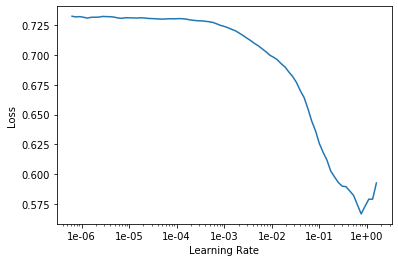

In [30]:
learn.recorder.plot()

In [30]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.173672,0.152018,0.070110,0.929890,03:55


In [31]:
learn.save('first1')

In [32]:
learn.load('first1');

In [33]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.059365,0.037876,0.119161,0.880839,04:32


In [34]:
learn.save('second1')

In [35]:
learn.load('second1');

In [36]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.035710,0.022514,0.100119,0.899881,06:54


In [37]:
learn.save('third1')

In [38]:
learn.load('third1');

In [39]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.030889,0.022529,0.104253,0.895747,08:58
1,0.029787,0.020403,0.107268,0.892733,09:20
2,0.026243,0.019122,0.091855,0.908145,09:54
3,0.026511,0.017227,0.103918,0.896082,09:52
4,0.022388,0.016839,0.092208,0.907792,09:11
5,0.021654,0.016016,0.102153,0.897847,09:54
6,0.019717,0.015661,0.096887,0.903113,09:12
7,0.017676,0.015873,0.094856,0.905144,09:38
8,0.017238,0.015643,0.101421,0.898579,09:52
9,0.016429,0.015824,0.087031,0.912969,09:03


In [40]:
learn.save('fourth1')

In [41]:
learn.load('fourth1');

### Build the Simple No Finding Classifier

In [20]:
### Simplify Dataset to Finding/No Finding
split = split[['study_id', 'subject_id', 'text', 'no_finding', 'split']]
split.head()

,study_id,subject_id,text,no_finding,split
0,58522792,16567081,"b"" FINAL REPOR...",0.0,train
1,58213163,16567081,b' FINAL REPOR...,0.0,train
2,59835582,16043746,b' FINAL REPOR...,1.0,train
3,51487790,16456872,b' FINAL REPOR...,1.0,train
4,59750073,16824069,b' FINAL REPOR...,1.0,train


In [21]:
split.count()[0]

227827

In [22]:
split.loc[split.no_finding==0.0].count()[0]

152372

In [23]:
split.loc[split.no_finding==1.0].count()[0]

75455

In [24]:
### Test/Train Split
train = split.loc[split.split=='train'].drop(columns=['split'])
test = split.loc[split.split=='test'].drop(columns=['split'])
validate = split.loc[split.split=='validate'].drop(columns=['split'])

test_nocats = test[['study_id', 'subject_id', 'text']]
test_nocats.head()

,study_id,subject_id,text
471,56536310,16524406,b' FINAL REPOR...
472,54985612,16524406,b' FINAL REPOR...
473,54562273,16524406,b' FINAL REPOR...
1000,54541565,16772702,b' FINAL REPOR...
1001,55198378,16772702,b' FINAL REPOR...


In [25]:
bs = 64
data_lm = load_data(path, 'data_lm1.pkl', bs=bs)
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)
learn.load('fine_tuned1')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (205052 items)
x: LMTextList
xxbos b ' xxup final xxup report 
  xxup examination : xxup chest ( xxup pa xxup and xxup lat ) 
 
  xxup indication : _ _ _ year old man with xxup copd , ankylosing spondylitis , new xxup sob , small 
  pleural effusion on spine films . / / ? xxunk effusion ? ? xxunk 
  effusion ? 
 
  xxup impression : 
 
  xxmaj comparison to _ _ _ . xxmaj the patient has developed a mild to moderate 
  right pleural effusion and a minimal left pleural effusion , better appreciated 
  on the lateral than on the frontal radiograph . xxmaj overinflation persists . xxmaj mild 
  pulmonary edema is present . xxmaj stable mild cardiomegaly . 
  ',xxbos b ' xxup final xxup report 
  xxup examination : xxup chest ( xxup pa xxup and xxup lat ) 
 
  xxup indication : _ _ _ m with reported pneumonia from xxup osh s / p dizziness , fall , head 
  strike / / evaluate for acute changes 
 
  xxup technique : xxup ap and lateral 


In [26]:
test_datalist = TextList.from_df(test_nocats, cols='text')

In [27]:
data_clas = (TextList.from_df(train, cols='text', vocab=data_lm.vocab)
                .split_by_rand_pct(valid_pct=0.1)
                .label_from_df(cols=['no_finding'], label_cls=CategoryList)
                .add_test(test_datalist)
                .databunch())
data_clas.save('data_clas1.pkl')

In [28]:
data_clas = load_data(path, 'data_clas1.pkl', bs=bs)

In [29]:
data_clas.show_batch()

text,target
"xxbos b ' xxup final xxup addendum \n xxup addendum xxmaj indication : xxmaj status post chest tube removal . \n \n xxup comparison : \n xxmaj earlier on the same day . \n \n xxup technique : xxmaj chest , xxup pa and lateral . \n \n xxup findings : \n \n \n \n xxmaj there is a persistent very small left apical",0.0
"xxbos b ' xxup wet xxup read : _ _ _ _ _ _ _ _ _ 7:08 xxup pm \n enteric tube distal side port at the xxup ge junction / distal esophagus , recommend \n advancement so that it is well within the stomach . xxup ett terminates 2.5 cm above \n carina . prominent ascending aorta and prominent density adjacent to the left \n",0.0
xxbos b ' xxup wet xxup read : _ _ _ _ _ _ _ _ _ 9:19 xxup am \n \n \n \n a xxup right - xxup sided xxup central xxup venous xxup catheter xxup terminates xxup in xxup the xxup lower xxup svc . xxup low xxup lung \n xxup volumes . xxup diffuse xxup bilateral xxup patchy xxup opacities xxup are xxup new xxup,0.0
xxbos b ' xxup final xxup report \n xxup examination : xxup chest ( xxup portable xxup ap ) \n \n xxup indication : _ _ _ year old man with food impaction and aspiration pneumonia s / p \n endoscopy with removal of food bolus / / interval change \n \n xxup comparison : xxmaj chest x - ray from _ _ _ at _,0.0
"xxbos b ' xxup final xxup report \n xxup history : xxmaj new onset pneumothorax status post chest tube to waterseal , question \n interval change . \n \n xxup chest , xxup single xxup ap xxup portable xxup view . \n \n xxup comparison : xxmaj chest x - ray dated _ _ _ at _ _ _ : _ _ _ p.m. \n \n",0.0


In [30]:
learn = text_classifier_learner(data_clas, AWD_LSTM, metrics=[accuracy, error_rate], drop_mult=0.5)
learn.load_encoder('fine_tuned_enc1')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (200475 items)
x: TextList
xxbos b " xxup final xxup report 
  xxup type xxup of xxup examination : xxmaj chest xxup pa and lateral . 
 
  xxup indication : _ _ _ -year - old male patient with recent pneumonia diagnosed and 
  treated at another facility . x - ray not available , now with continued cough 
  and wheeze , history of xxup copd , remaining evidence of pneumonia ? 
 
  xxup findings : xxup pa and lateral chest views were obtained with patient in upright 
  position . xxmaj analysis is performed in direct comparison with the next preceding 
  chest examination of _ _ _ . xxmaj the heart size remains normal . xxmaj no 
  typical configurational abnormality is seen . xxmaj the thoracic aorta is moderately 
  widened and somewhat elongated but no local contour abnormalities are 
  identified . xxmaj the pulmonary vasculature is not congested . xxmaj there exists , 
  however , some irregular peripheral vascular distribution m

In [31]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


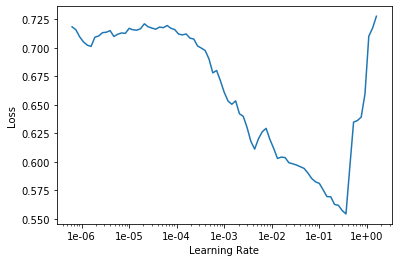

In [32]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.264739,0.204717,0.915825,0.084175,03:44


In [34]:
learn.save('first1')

In [35]:
learn.load('first1');

In [36]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.097256,0.071160,0.974456,0.025544,04:46


In [37]:
learn.save('second1')

In [38]:
learn.load('second1');

In [39]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.048834,0.041332,0.986442,0.013558,07:00


In [40]:
learn.save('third1')

In [41]:
learn.load('third1');

In [42]:
learn.unfreeze()
learn.fit_one_cycle(10, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.043825,0.040237,0.986981,0.013019,09:47
1,0.046727,0.037369,0.987924,0.012076,09:06
2,0.034319,0.032891,0.989809,0.010191,08:53
3,0.032254,0.033761,0.989630,0.010370,09:01
4,0.028290,0.030614,0.990079,0.009921,09:24
5,0.027618,0.030000,0.990572,0.009428,09:08
6,0.024705,0.029964,0.990572,0.009428,09:19
7,0.021419,0.032057,0.990393,0.009607,08:42
8,0.020135,0.031065,0.990797,0.009203,09:30
9,0.018474,0.032036,0.990438,0.009562,09:02


In [43]:
learn.save('fourth1')

In [44]:
learn.load('fourth1');

# Predict

In [ ]:
learn.predict("INSERT MEDSTAR SAMPLE TEXT HERE")

In [ ]:
test_id = test['id']
preds, target = learn.get_preds(DatasetType.Test, ordered=True)
labels = preds.numpy()
submission = pd.DataFrame({'id': test_id})
submission = pd.concat([submission, pd.DataFrame(preds.numpy(), columns = label_cols)], axis=1)
submission.to_csv('submission.csv', index=False)
submission.head()